# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0831s3"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1018, 32, 20, 3)
(1018, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/400


C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


255/255 [==============================] - 3s 8ms/step - loss: 2.1188 - accuracy: 0.3766
Epoch 2/400
255/255 [==============================] - 2s 8ms/step - loss: 1.4877 - accuracy: 0.5412
Epoch 3/400
255/255 [==============================] - 2s 7ms/step - loss: 1.0438 - accuracy: 0.6673
Epoch 4/400
255/255 [==============================] - 2s 7ms/step - loss: 0.8568 - accuracy: 0.7191
Epoch 5/400
255/255 [==============================] - 2s 7ms/step - loss: 0.7385 - accuracy: 0.7575
Epoch 6/400
255/255 [==============================] - 2s 7ms/step - loss: 0.6502 - accuracy: 0.8155
Epoch 7/400
255/255 [==============================] - 2s 7ms/step - loss: 0.5496 - accuracy: 0.8394
Epoch 8/400
255/255 [==============================] - 2s 7ms/step - loss: 0.5017 - accuracy: 0.8443
Epoch 9/400
255/255 [==============================] - 3s 10ms/step - loss: 0.4331 - accuracy: 0.8500
Epoch 10/400
255/255 [==============================] - 2s 8ms/step - loss: 0.4640 - accuracy: 0.8580


255/255 [==============================] - 2s 9ms/step - loss: 0.1120 - accuracy: 0.9725
Epoch 82/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0506 - accuracy: 0.9837
Epoch 83/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0645 - accuracy: 0.9792
Epoch 84/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0803 - accuracy: 0.9731
Epoch 85/400
255/255 [==============================] - 2s 10ms/step - loss: 0.1032 - accuracy: 0.9691
Epoch 86/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0577 - accuracy: 0.9809
Epoch 87/400
255/255 [==============================] - 2s 8ms/step - loss: 0.0570 - accuracy: 0.9832
Epoch 88/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0568 - accuracy: 0.9787
Epoch 89/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0881 - accuracy: 0.9780
Epoch 90/400
255/255 [==============================] - 2s 9ms/step - loss: 0.1064 - accuracy:

255/255 [==============================] - 2s 9ms/step - loss: 0.0791 - accuracy: 0.9782
Epoch 161/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0432 - accuracy: 0.9874
Epoch 162/400
255/255 [==============================] - 2s 9ms/step - loss: 0.1099 - accuracy: 0.9833
Epoch 163/400
255/255 [==============================] - 2s 8ms/step - loss: 0.0593 - accuracy: 0.9854
Epoch 164/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0187 - accuracy: 0.9934
Epoch 165/400
255/255 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.96 - 2s 9ms/step - loss: 0.0781 - accuracy: 0.9656
Epoch 166/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0515 - accuracy: 0.9827
Epoch 167/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0678 - accuracy: 0.9786
Epoch 168/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0621 - accuracy: 0.9805
Epoch 169/400
255/255 [======================

255/255 [==============================] - 2s 9ms/step - loss: 0.0285 - accuracy: 0.9887
Epoch 239/400
255/255 [==============================] - 2s 8ms/step - loss: 0.0635 - accuracy: 0.9890
Epoch 240/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0184 - accuracy: 0.9953
Epoch 241/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0386 - accuracy: 0.9883
Epoch 242/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0318 - accuracy: 0.9888
Epoch 243/400
255/255 [==============================] - 2s 8ms/step - loss: 0.0399 - accuracy: 0.9858
Epoch 244/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0397 - accuracy: 0.9884
Epoch 245/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0530 - accuracy: 0.9826
Epoch 246/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0214 - accuracy: 0.9963
Epoch 247/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0487 - a

255/255 [==============================] - 2s 9ms/step - loss: 0.0229 - accuracy: 0.9897
Epoch 318/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0232 - accuracy: 0.9949
Epoch 319/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0566 - accuracy: 0.9893
Epoch 320/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0828 - accuracy: 0.9853
Epoch 321/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0301 - accuracy: 0.9949
Epoch 322/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0168 - accuracy: 0.9940
Epoch 323/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0542 - accuracy: 0.9888
Epoch 324/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0404 - accuracy: 0.9882
Epoch 325/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0222 - accuracy: 0.9883
Epoch 326/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0553 - a

255/255 [==============================] - 2s 9ms/step - loss: 0.0138 - accuracy: 0.9973
Epoch 396/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0494 - accuracy: 0.9889
Epoch 397/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0454 - accuracy: 0.9869
Epoch 398/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0516 - accuracy: 0.9880
Epoch 399/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0107 - accuracy: 0.9955
Epoch 400/400
255/255 [==============================] - 2s 9ms/step - loss: 0.0570 - accuracy: 0.9818


### Learing result
 
* Visualization of the training and validation results

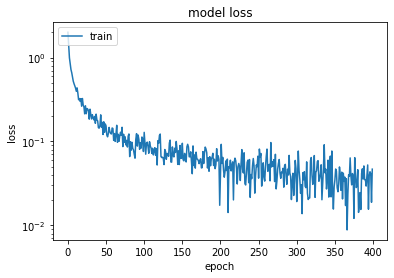

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


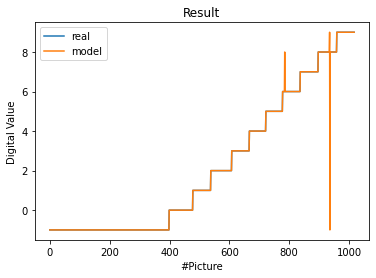

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpfhr2e7j0\assets


219388

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmph6wrzsvw\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmph6wrzsvw\assets


63824

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ziffer_sortiert_resize/6\20200815-182914_digit3.jpg 6 8
ziffer_sortiert_resize/8\D6_2020-08-12_11-48-43.jpg 8 9
ziffer_sortiert_resize/8\D6_2020-08-16_19-50-10.jpg 8 NaN


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.